In [1]:
import pandas as pd
import xarray as xr
import cfgrib
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from cdo import *
cdo = Cdo()

## Functions

In [2]:
def load_data():
    

    #Define input data path
    file_path_start = './data/' 
    #ERA 5
    file_name_era5_start = 'era5-monthly-seasonal-forecast-total-precipitation'
    file_path_era5 = file_path_start + file_name_era5_start + '-1981-2023-tcd.grib'
    file_path_era5_1deg = file_path_start + file_name_era5_start + '-1981-2023-tcd_1deg.grib'
    #ECMWF
    file_name_ecmwf_start = 'ecmwf-monthly-seasonalforecast-1981-2023-tcd.grib'
    file_path_ecmwf = file_path_start + file_name_ecmwf_start

    ds_ecmwf = xr.open_dataset(file_path_ecmwf, engine="cfgrib")
    input_ecmwf_df = ds_ecmwf.to_dataframe().dropna().reset_index()

    if False: #to do: add check to see if low-resolution for ERA5 is available
        cdo.remapcon(file_path_ecmwf,input = file_path_era5, output = file_path_era5_1deg, force =  False)

    ds_era5 = xr.open_dataset(file_path_era5_1deg, engine="cfgrib")
    input_era5_df = ds_era5.to_dataframe().dropna().reset_index()

    return input_ecmwf_df, input_era5_df

In [3]:
def pre_process_data_single_df(input_df, data_source):

    output_col = ['date_year','date_month','lead_time','latitude','longitude','tp_mm_day']
    
    #format data
    df = input_df.copy()
    #rounding resolution here because the grid interpolation doesn't give exact results. Should improve this by some other method 
    df['latitude'] = df['latitude'].apply(lambda x : round(x,2))
    df['longitude'] = df['longitude'].apply(lambda x : round(x,2))
    df.rename(columns={"tprate": "tp_mm_day", "tp": "tp_mm_day"}, inplace = True, errors= 'ignore')
    
    
    #Compute lead time in months for ecmwf
    if (data_source == 'ecmwf'): 
        df['lead_time'] = 0
        for lead_days in df['step'].unique():
            lead_months = round(float(str(lead_days).split(" ")[0])/30)
            df.loc[df['step'] == lead_days, 'lead_time'] = lead_months
    else:
        df['lead_time'] = 0
        
    #Esnemble mean for ECMWF (51 models)
    if (data_source == 'ecmwf'):
        df = df.groupby(['latitude','longitude','valid_time','lead_time'])['tp_mm_day'].mean().reset_index() 
    
    
    #Correct valid time convention. ERA5 shift comes from the CDO grid matching, not sure why
    df['date_year'] = df['valid_time'].apply(lambda x : x.year)
    if (data_source == 'ecmwf'): 
        df['date_month'] = df['valid_time'].apply(lambda x : x.month-1)
        df.loc[df['date_month'] == 0, 'date_month'] = 12
    else:
        df['date_month'] = df['valid_time'].apply(lambda x : x.month+1)
        df.loc[df['date_month'] == 13, 'date_month'] = 1
        
    
    
    #Each source use a different unit (meters/day for ERA5 and meters/second for ECMWF). Converting both on mm/day here
    if (data_source == 'ecmwf'):
        df['tp_mm_day'] = df['tp_mm_day']*1000*60*60*24
    else:
        df['tp_mm_day'] = df['tp_mm_day']*1000
    
    df = df[output_col]


    return(df)

    

In [4]:
def pre_process_data(input_ecmwf_df, input_era5_df):
    
    ecmwf_df = pre_process_data_single_df(input_ecmwf_df, 'ecmwf')
    era5_df = pre_process_data_single_df(input_era5_df, 'era5')
    
    merge_df = pd.merge(ecmwf_df, era5_df, on=['date_year','date_month','latitude','longitude'], suffixes=('_ecmwf', '_era5'))
    merge_df['bias'] = merge_df['tp_mm_day_ecmwf'] - merge_df['tp_mm_day_era5']
    merge_df['mae'] = abs(merge_df['bias'])

    return ecmwf_df, era5_df, merge_df

In [103]:
def plot_leadtime_month_dependency(merge_df):
    
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 18))

    for row in range(3):
        for col in range(2):
            if (row == 1 and col == 0):
                vx = 'latitude'
                vx_name = 'latitude'
            elif (row == 1 and col == 1):
                vx = 'longitude'
                vx_name = 'longitude'
            elif col == 0:      
                vx = 'lead_time_ecmwf'
                vx_name = 'lead time'
                vy = 'date_month'
                vy_name = 'month'  
            else:
                vx = 'date_month'
                vx_name = 'month'   
                vy = 'lead_time_ecmwf'
                vy_name = 'lead time'
        
            
            ax = axs[row, col]
            if row == 0:
                ax.set_title('Error metric evolution with ' + vx_name)
                score_df = merge_df.groupby(['lead_time_ecmwf','date_month'])[['bias','mae']].mean().reset_index()
                plot_df = score_df.groupby(vx)[['bias','mae']].mean().reset_index()
                ax.plot(plot_df[vx],plot_df.mae, label = 'MAE')
                ax.plot(plot_df[vx],plot_df.bias, label = 'Bias')
                
            elif row == 1:  
                ax.set_title('Error metric evolution with ' + vx_name)
                plot_df = merge_df.groupby(vx)[['bias','mae']].mean().reset_index()
                ax.plot(plot_df[vx],plot_df.mae, label = 'MAE')
                ax.plot(plot_df[vx],plot_df.bias, label = 'Bias')
                
            elif row == 2:  
                ax.set_title('Bias evolution with month and lead time')
                score_df = merge_df.groupby(['lead_time_ecmwf','date_month'])[['bias','mae']].mean().reset_index()
                for i in range(1,len(score_df[vy].unique())):
                    plot_df = score_df[score_df[vy] == i]
                    ax.plot(plot_df[vx],plot_df.bias, label = vy_name + ' = ' + str(i))
                
            
            ax.set_xlabel(vx_name)
            ax.set_ylabel("Error metric (mm/day)")
            ax.legend(loc='best')


In [119]:
def plot_climatology(era5_df, ecmwf_df):

    era5_month_df = era5_df.groupby('date_month')['tp_mm_day'].mean().reset_index()
    ecmwf_month_df = ecmwf_df.groupby(['lead_time','date_month'])['tp_mm_day'].mean().reset_index()
    
    fig,ax = plt.subplots()
    
    
    ax.plot(era5_month_df.date_month,era5_month_df.tp_mm_day, label = 'era5')
    for i in range(1,7):
        ecmwf_month_df_plot = ecmwf_month_df[ecmwf_month_df['lead_time'] == i]
        ax.plot(ecmwf_month_df_plot.date_month,ecmwf_month_df_plot.tp_mm_day, label = 'lead_time: ' + str(i))
    
    ax.set_title('Precipitation bias per month and lead time (country average)')
    ax.set_xlabel("month")
    ax.set_ylabel("precipitation bias (mm / day)")
    
    ax.legend(loc='best')

## Analysis

In [5]:
input_ecmwf_df, input_era5_df = load_data()


In [6]:
ecmwf_df, era5_df, merge_df = pre_process_data(input_ecmwf_df, input_era5_df)


In [122]:
#export ERA5 / ECMWF climatology per grid point
era5_df.groupby(['latitude','longitude'])['tp_mm_day'].mean().reset_index().to_csv('./data/era5_average_per_grid.csv')
ecmwf_df[ecmwf_df['lead_time'] == 1].groupby(['latitude','longitude'])['tp_mm_day'].mean().reset_index().to_csv('./data/ecmwf_average_per_grid.csv')
#bias per grid point
merge_df[merge_df.lead_time_ecmwf == 1].groupby(['latitude','longitude'])[['bias','mae']].mean().reset_index().to_csv('./data/error_per_grid.csv')

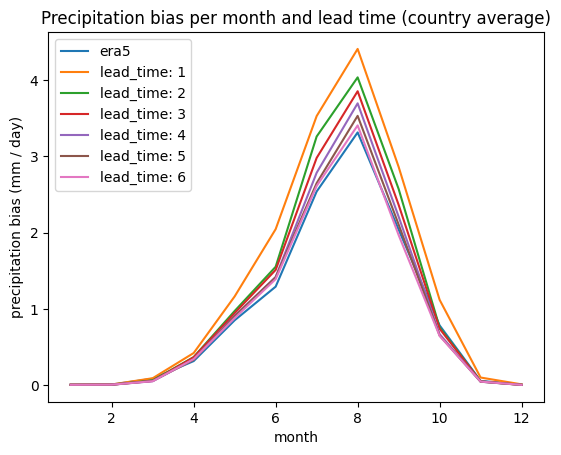

In [120]:
plot_climatology(era5_df, ecmwf_df)

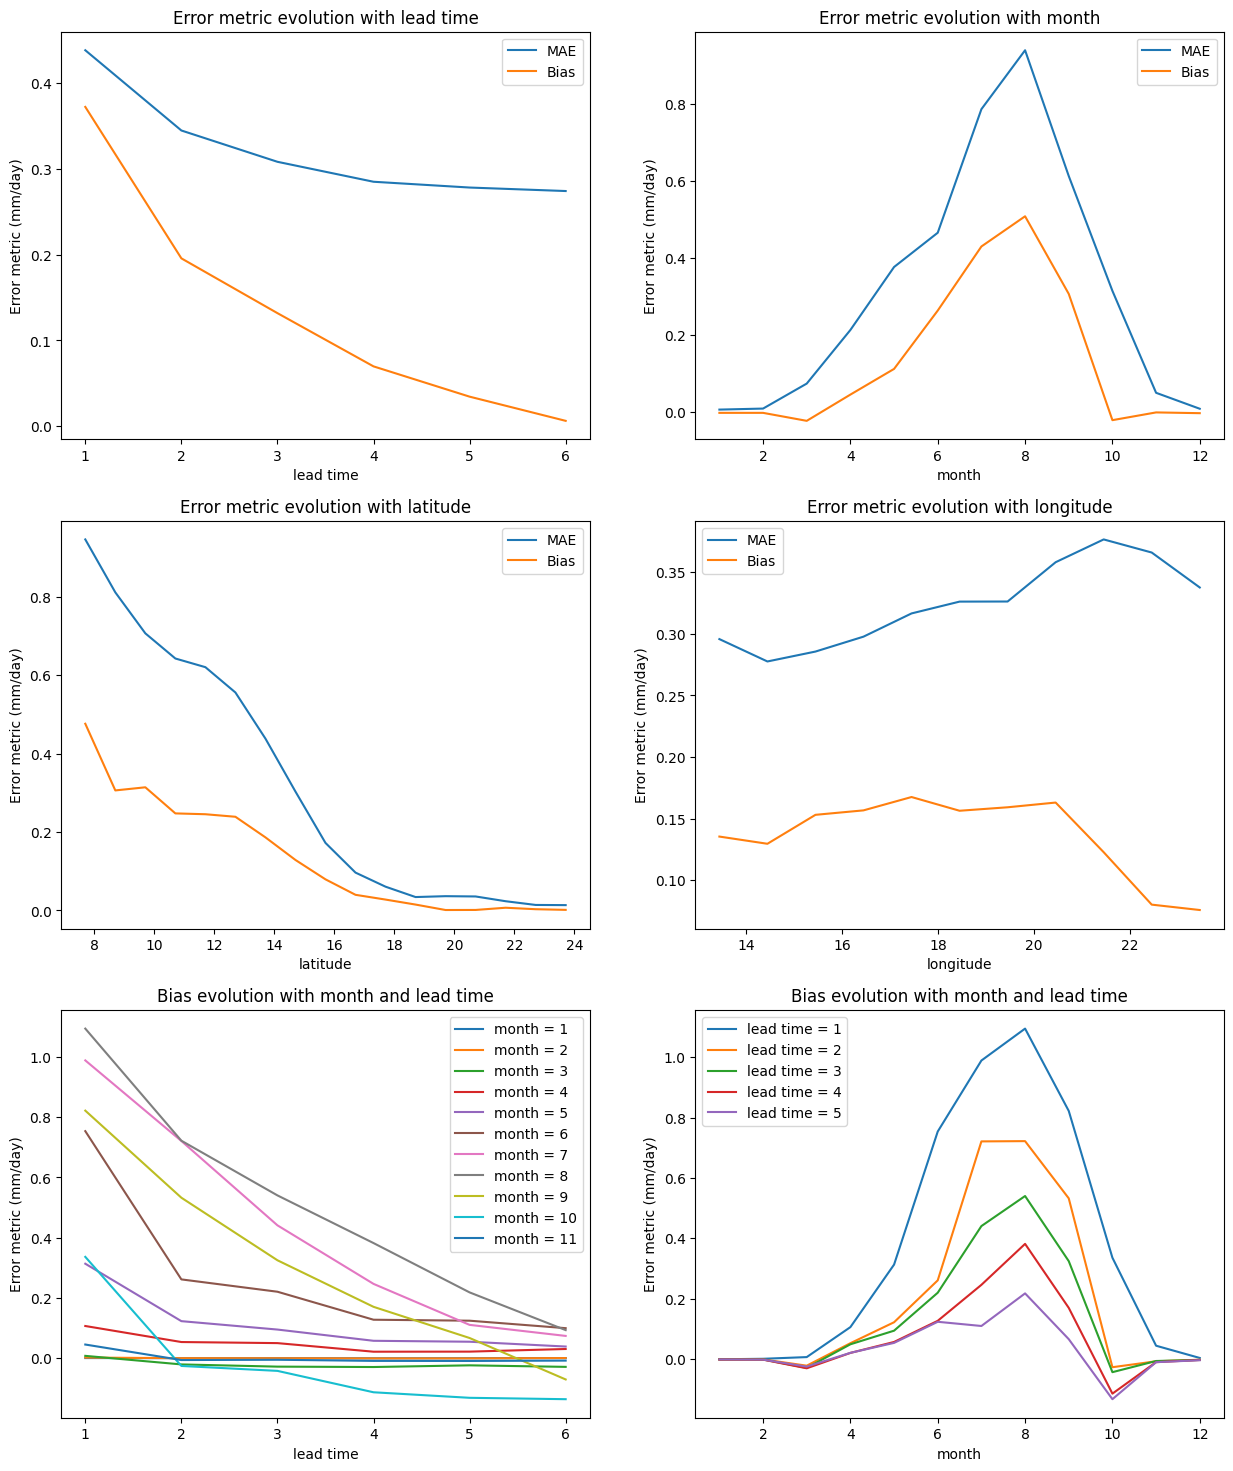

In [114]:
plot_leadtime_month_dependency(merge_df)


## Sandbox

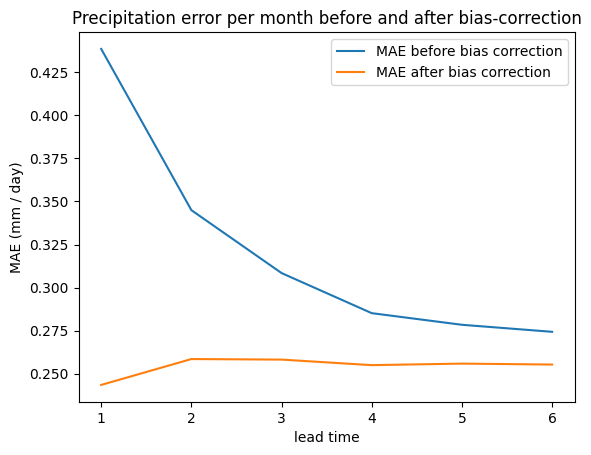

In [164]:
merge_df_avg = merge_df.groupby(['latitude','longitude','date_month','lead_time_ecmwf'])[['tp_mm_day_ecmwf','tp_mm_day_era5']].mean().reset_index()
merge_df_std = merge_df.groupby(['latitude','longitude','date_month','lead_time_ecmwf'])[['tp_mm_day_ecmwf','tp_mm_day_era5']].std().reset_index()
merge_df_q1 = merge_df.groupby(['latitude','longitude','date_month'])['tp_mm_day_era5'].quantile(1/3).reset_index()
merge_df_q2 = merge_df.groupby(['latitude','longitude','date_month'])['tp_mm_day_era5'].quantile(2/3).reset_index()

merge_df_avg.rename(columns = {'tp_mm_day_ecmwf' : 'tp_mm_day_ecmwf_avg', 'tp_mm_day_era5' : 'tp_mm_day_era5_avg'}, inplace = True)
merge_df_std.rename(columns = {'tp_mm_day_ecmwf' : 'tp_mm_day_ecmwf_std', 'tp_mm_day_era5' : 'tp_mm_day_era5_std'}, inplace = True)
merge_df_q1.rename(columns = {'tp_mm_day_era5' : 'tp_mm_day_era5_q1'}, inplace = True)
merge_df_q2.rename(columns = {'tp_mm_day_era5' : 'tp_mm_day_era5_q2'}, inplace = True)


corr_df = pd.merge(merge_df_avg, merge_df_std, on=['lead_time_ecmwf','date_month','latitude','longitude'])
corr_df = pd.merge(merge_df,corr_df,on=['lead_time_ecmwf','date_month','latitude','longitude'])
corr_df = pd.merge(corr_df,merge_df_q1,on=['date_month','latitude','longitude'])
corr_df = pd.merge(corr_df,merge_df_q2,on=['date_month','latitude','longitude'])

corr_df['tp_mm_day_ecmwf_corr'] = (corr_df['tp_mm_day_ecmwf'] - corr_df['tp_mm_day_ecmwf_avg'])  + corr_df['tp_mm_day_era5_avg']

corr_df['bias_corr'] = corr_df['tp_mm_day_ecmwf_corr'] - corr_df['tp_mm_day_era5']
corr_df['mae_corr'] = abs(corr_df['bias_corr'])


fig,ax = plt.subplots()

bias_per_lead_time_df = merge_df.groupby(['lead_time_ecmwf','date_month'])[['bias','mae']].mean().reset_index()
plot_df = bias_per_lead_time_df.groupby('lead_time_ecmwf')['mae'].mean().reset_index()
ax.plot(plot_df.lead_time_ecmwf, plot_df.mae, label = 'MAE before bias correction')


bias_per_lead_time_df_corr = corr_df.groupby(['lead_time_ecmwf','date_month'])[['bias_corr','mae_corr']].mean().reset_index()
plot_df = bias_per_lead_time_df_corr.groupby('lead_time_ecmwf')['mae_corr'].mean().reset_index()
ax.plot(plot_df.lead_time_ecmwf, plot_df.mae_corr, label = 'MAE after bias correction')

ax.set_title('Precipitation error per month before and after bias-correction')
ax.set_xlabel("lead time")
ax.set_ylabel("MAE (mm / day)")

ax.legend(loc='best')

In [166]:
corr_df['era5_tercile'] = 'medium'
corr_df['ecmwf_tercile'] = 'medium'

corr_df.loc[corr_df.tp_mm_day_era5 < corr_df.tp_mm_day_era5_q1, 'era5_tercile'] = 'low'
corr_df.loc[corr_df.tp_mm_day_era5 > corr_df.tp_mm_day_era5_q2, 'era5_tercile'] = 'high'

corr_df.loc[corr_df.tp_mm_day_ecmwf_corr < corr_df.tp_mm_day_era5_q1, 'ecmwf_tercile'] = 'low'
corr_df.loc[corr_df.tp_mm_day_ecmwf_corr > corr_df.tp_mm_day_era5_q2, 'ecmwf_tercile'] = 'high'

corr_df['score'] = 0
corr_df.loc[(corr_df.ecmwf_tercile == 'low') & (corr_df.era5_tercile == 'low'),'score'] = 1
corr_df.loc[(corr_df.ecmwf_tercile != 'low') & (corr_df.era5_tercile != 'low'),'score'] = 1

In [167]:
corr_df[corr_df.lead_time_ecmwf == 1].groupby(['latitude','longitude'])[['score']].mean().reset_index().to_csv('./data/accuracy_per_grid.csv')

In [168]:
acc_df = corr_df.groupby(['latitude','longitude','lead_time_ecmwf'])[['score']].mean().reset_index()

In [149]:
df.score.min()

0.4669260700389105

In [157]:
corr_df.lead_time_ecmwf.unique()

array([1, 2, 3, 4, 5, 6])

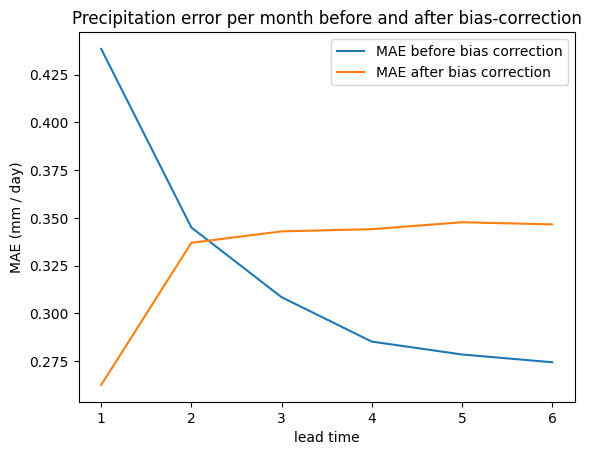

In [165]:
corr_df[corr_df.lead_time_ecmwf == 1].groupby(['latitude','longitude'])[['bias_corr','mae_corr']].mean().reset_index().to_csv('./data/error_corr_per_grid.csv')




<Axes: xlabel='tp_mm_day_era5', ylabel='tp_mm_day_ecmwf_corr'>

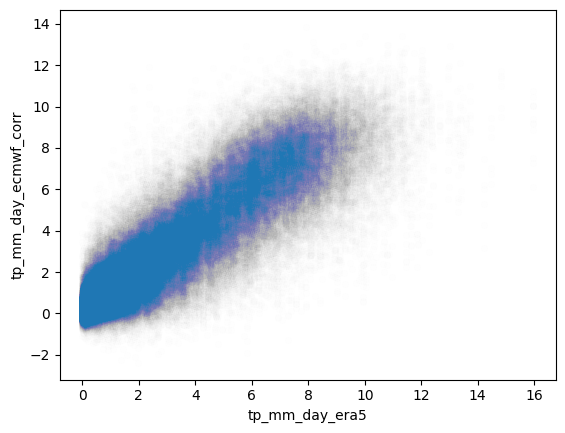

In [132]:

corr_df.plot.scatter(x = 'tp_mm_day_era5', y = 'tp_mm_day_ecmwf_corr', alpha = 0.005)

In [133]:
corr_df['tp_mm_day_era5'].corr(corr_df['tp_mm_day_ecmwf_corr'])

0.9298187816554441